# TOC
use `[Another Cell](#another_cell)` to point to a cell contains `<a id='another_cell'></a>`

[All-in-One df](#All-in-One-df)
***
[csky-set-up](#csky-set-up)
***
[grb-list](#grb-list)
***
[healpix-map](#healpix-map)
***
[greco-datesets](#greco-datesets)
***
[time-windows](#time-windows)
***
[Analysis](#Analysis)
 - [background scan](#background-scan)
    - [background-illustration](#background-illustration) 
    - [background-TS-distribution](#background-TS-distribution)

In [1]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from utils import *


#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/version-002-p04
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [2]:
if 0:
    stay_awake(180)

# All-in-One df
<a id='All-in-One-df'></a>

In [3]:

df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_healpix_nside64.pkl")

In [4]:
df.head()

,grb_name,grb_name_GBM,ra,dec,mjd_start,t100,t90,gbm,source_uncertainty,redshift,t_center,hasHealpix,probs
0,GRB190613B,GRB190613449,305.431917,-4.646667,58647.449285,0.001905,0.000056,0,0.000056,NaN,58647.450238,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,GRB190613A,GRB190613172,182.529208,67.235278,58647.171736,0.000204,0.000198,0,0.000056,NaN,58647.171838,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,GRB190612A,GRB190612165,223.950000,62.100000,58646.164836,0.001677,0.001677,1,7.025096,NaN,58646.165675,True,"[1.8016500009675246e-06, 2.0288993030385598e-0..."
3,GRB190611B,GRB190611950,84.758333,50.833333,58645.949833,0.001217,0.001164,0,5.900000,NaN,58645.950442,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,GRB190611A,None,324.722625,-56.074278,58645.742373,0.000484,0.000484,0,0.000194,NaN,58645.742615,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Csky set up
<a id='csky-set-up'></a>

In [5]:
print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data_with_angErr.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged_with_angErr.npy'))
# load numu only to save memory, never used in this .py
# sig_filenames = sorted(glob(data_dir + '/IC86_2012.numu_merged_with_angErr.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
bins_logenergy = np.linspace(min_log_e, 5, 30+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.4', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
# on OSG
# ana_dir = "./"
ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=False)  # to save memory  





===== Setting up csky =====

Setting up Analysis for:
greco_v2.4
Setting up greco_v2.4...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [6]:
conf = {
    'ana': ana,
    #### llh basics: csky.conf
    'space': 'ps', # ps/fitps/template/prior
    'time': 'transient', # utf/lc/transient
    'energy': 'customflux', # fit/customflux
    'flux': cy.hyp.PowerLawFlux(2),
    #### inj.py - prior has some duplications against space's prior
    'sig': 'transient', # ps/tw/lc/transient/template/prior
    'full_sky': True,
    'extended': True,
    'mp_cpus': 4,
    'cut_n_sigma': 3
    }

cy.CONF.update(conf)

# GRB List
<a id='grb-list'></a>

## t100 distribution

In [7]:
hl.hist(df.t100*86400.
         ,bins=np.r_[np.logspace(np.log10(0.001), np.log10(2.5), 20, endpoint=False), np.logspace(np.log10(2.5), np.log10(10000), 20)])

Hist(39 bins in [0.001,10000.0], with sum 2051.0, 10 empty bins, and 0 non-finite values)

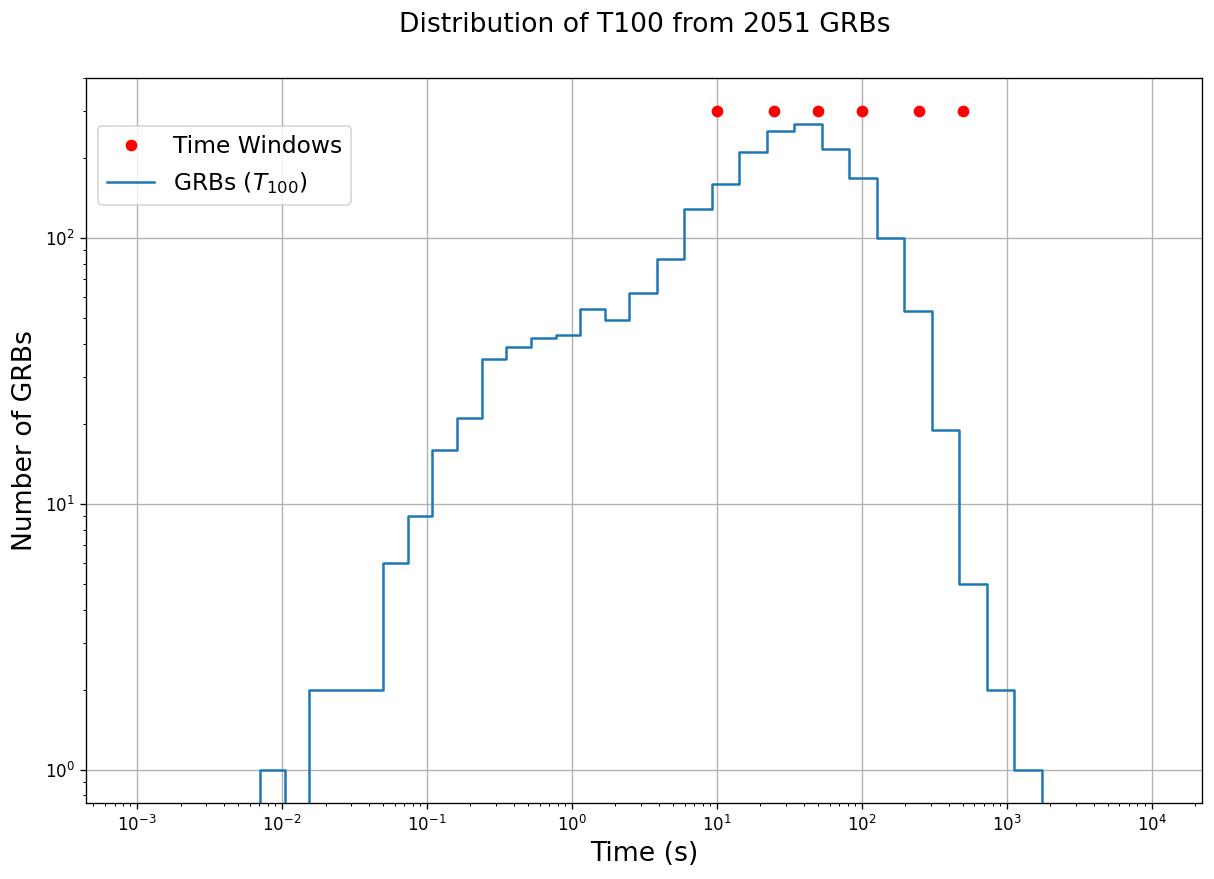

In [8]:
fig, ax = plt.subplots(figsize=(12,8), dpi=120)

h = hl.hist (df.t100*86400.
             ,bins=np.r_[
                 np.logspace(np.log10(0.001), np.log10(2.5), 20, endpoint=False), 
                 np.logspace(np.log10(2.5), np.log10(10000), 20)
             ])
hl.plot1d (ax, h, label=r'GRBs ($T_{100}$)')

ax.plot([10,25,50,100,250,500], np.ones(6)+300, 'ro', label="Time Windows")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Time (s)', fontsize=16)
ax.set_ylabel('Number of GRBs', fontsize=16)
ax.grid(True)
ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.0, 0.95), fontsize=14)
ax.set_title('Distribution of T100 from {} GRBs'.format(len(df.t100)), fontsize=16, y=1.05)
plt.show()

## angular and spatial separation

In [9]:
"""
grb_pairs = []
mjd_separation = []
angular_separation = []
with time('get separation'):
    for i in df.index[:]:
        if i % 10 == 0: print("i: ", i)
        for j in df.index[i+1:]:
            grb_pair = set([df.grb_name[i], df.grb_name[j]])
            mjd_diff = abs(df['mjd_start'][i] - df['mjd_start'][j])
            ang_diff = cy.coord.delta_angle(
                np.deg2rad(df.dec[i])
                , np.deg2rad(df.ra[i])
                , np.deg2rad(df.dec[j])
                , np.deg2rad(df.ra[j])
                , latlon=True)
            grb_pairs.append(grb_pair)
            mjd_separation.append(mjd_diff)
            angular_separation.append(np.rad2deg(ang_diff))
grb_pairs = np.array(grb_pairs)
mjd_separation = np.array(mjd_separation)
angular_separation = np.array(angular_separation)
separation_df = pd.DataFrame({
    'grb_pair': grb_pairs, 
    'mjd_diff': mjd_separation, 
    'angular_diff': angular_separation
})
separation_df.to_pickle(DATA_DIR+"/plot/Proximities.pkl")
"""

'\ngrb_pairs = []\nmjd_separation = []\nangular_separation = []\nwith time(\'get separation\'):\n    for i in df.index[:]:\n        if i % 10 == 0: print("i: ", i)\n        for j in df.index[i+1:]:\n            grb_pair = set([df.grb_name[i], df.grb_name[j]])\n            mjd_diff = abs(df[\'mjd_start\'][i] - df[\'mjd_start\'][j])\n            ang_diff = cy.coord.delta_angle(\n                np.deg2rad(df.dec[i])\n                , np.deg2rad(df.ra[i])\n                , np.deg2rad(df.dec[j])\n                , np.deg2rad(df.ra[j])\n                , latlon=True)\n            grb_pairs.append(grb_pair)\n            mjd_separation.append(mjd_diff)\n            angular_separation.append(np.rad2deg(ang_diff))\ngrb_pairs = np.array(grb_pairs)\nmjd_separation = np.array(mjd_separation)\nangular_separation = np.array(angular_separation)\nseparation_df = pd.DataFrame({\n    \'grb_pair\': grb_pairs, \n    \'mjd_diff\': mjd_separation, \n    \'angular_diff\': angular_separation\n})\nseparation

In [10]:
## works on HIVE
separation_df = pd.read_pickle(DATA_DIR+"/plot/Proximities.pkl")
separation_df['mjd_diff_seconds'] = separation_df["mjd_diff"] * 86400.
separation_df.head()

,grb_pair,mjd_diff,angular_diff,mjd_diff_seconds
0,"{GRB190613A, GRB190613B}",0.277549,106.511325,23980.257
1,"{GRB190613B, GRB190612A}",1.284449,90.143918,110976.425
2,"{GRB190611B, GRB190613B}",1.499452,122.700338,129552.658
3,"{GRB190611A, GRB190613B}",1.706913,53.681731,147477.257
4,"{GRB190613B, GRB190610C}",2.615705,14.577721,225996.876


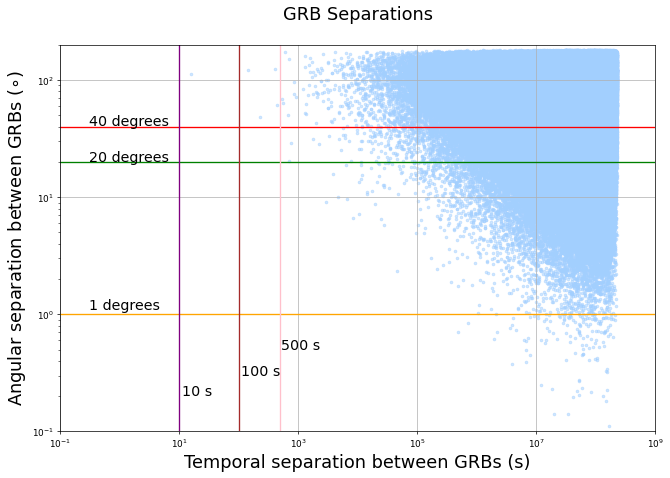

In [11]:
fig, ax = plt.subplots(figsize=(12,8), dpi=64)

ax.scatter(separation_df['mjd_diff_seconds']
           , separation_df['angular_diff']
           , c="#a2cffe"
           , marker='.'
           , alpha = 0.5)

ax.axhline(1,color = 'orange')
ax.text(0.3, 1.1, '1 degrees', fontsize=16)
ax.axhline(20,color = 'green')
ax.text(0.3, 20.1, '20 degrees', fontsize=16)
ax.axhline(40,color = 'red')
ax.text(0.3, 41, '40 degrees', fontsize=16)

ax.axvline(10, color = 'purple')
ax.text(11, .2, '10 s', fontsize=16)
ax.axvline(100, color = 'brown')
ax.text(110, .3, '100 s', fontsize=16)
ax.axvline(500, color = 'pink')
ax.text(510, .5, '500 s', fontsize=16)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Temporal separation between GRBs (s)', fontsize=20)
ax.set_ylabel(r'Angular separation between GRBs ($\circ$)', fontsize=20)
ax.set_xlim(1e-1,1e9)
ax.set_ylim(1e-1,2e2)
ax.grid(True)
# ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.0, 0.95), fontsize=16)
ax.set_title('GRB Separations', fontsize=20, y=1.05)
plt.show()

# Healpix Map
<a id='healpix-map'></a>

## real healpix example: GRB180423A

/storage/hive/project/phy-taboada/cchen641/icecube/software/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon, lat, Z, **kw)


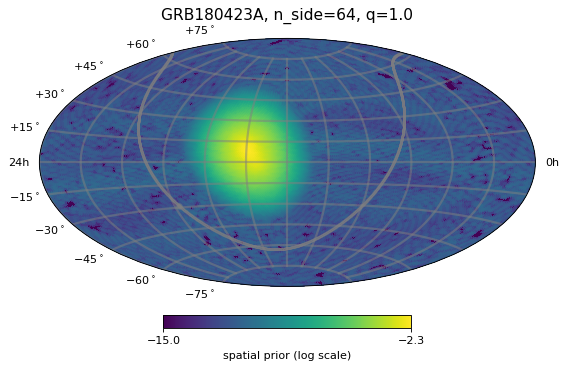

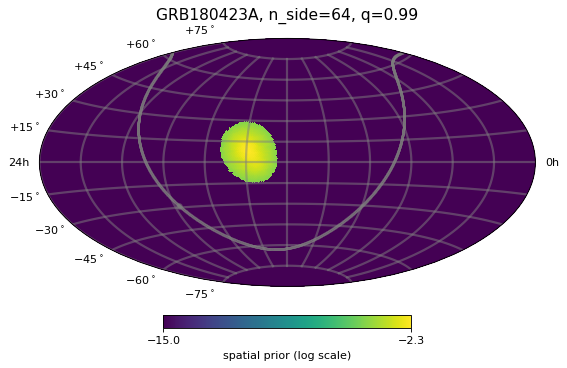

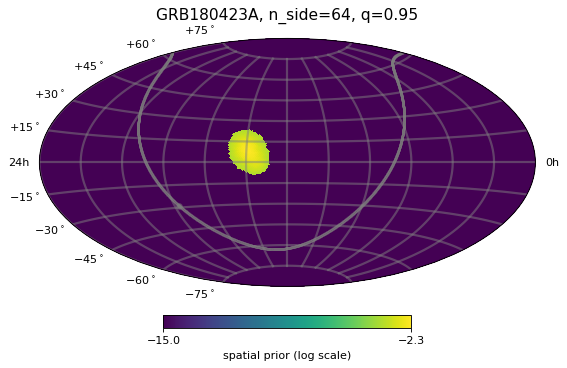

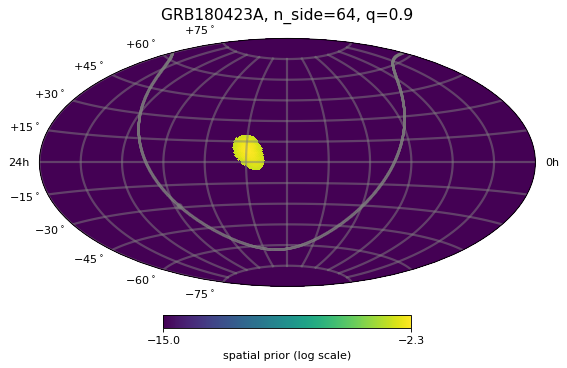

In [12]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB180423A"))
for q in [1.0, 0.99, 0.95, 0.90]:
    healpix[healpix < isf_healpix(healpix, q=q)] = 0
    fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict())
    mesh, cb = sp.plot_map(ax, np.log10(np.maximum(healpix, 1e-15)), n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'spatial prior (log scale)')
    ax.set_title("GRB180423A, n_side=64, q={}".format(q), fontsize=14, y=1.05)
    # plt.tight_layout()
    plt.show()


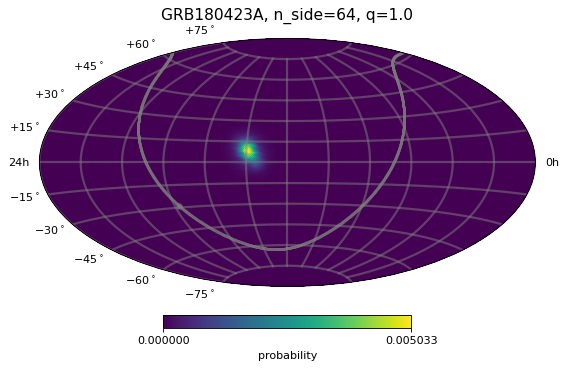

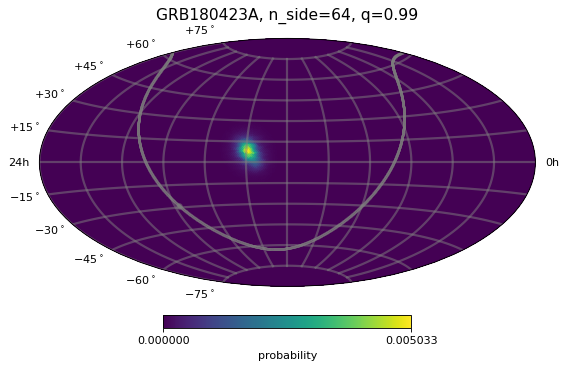

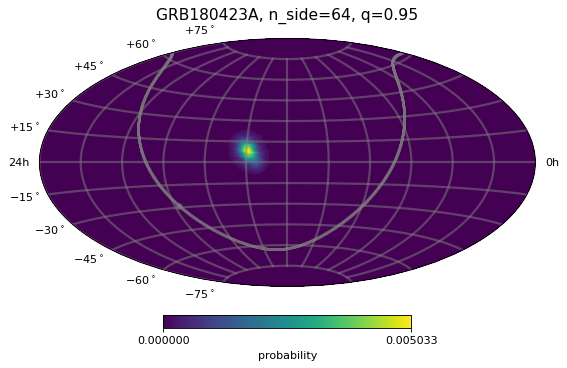

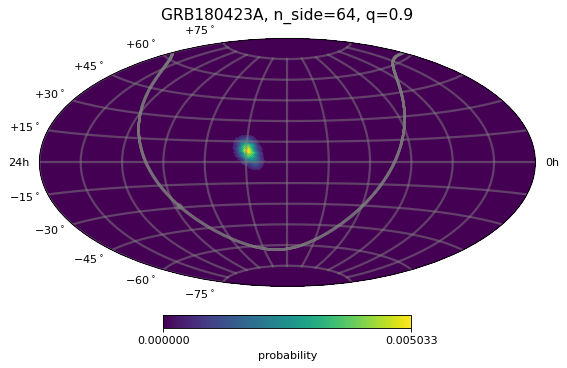

In [13]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB180423A"))
for q in [1.0, 0.99, 0.95, 0.90]:
    healpix[healpix < isf_healpix(healpix, q=q)] = 0
    fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict())
    mesh, cb = sp.plot_map(ax, healpix, 1e-15, n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'probability')
    ax.set_title("GRB180423A, n_side=64, q={}".format(q), fontsize=14, y=1.05)
    # plt.tight_layout()
    plt.show()



## fake healpix example: GRB190611B

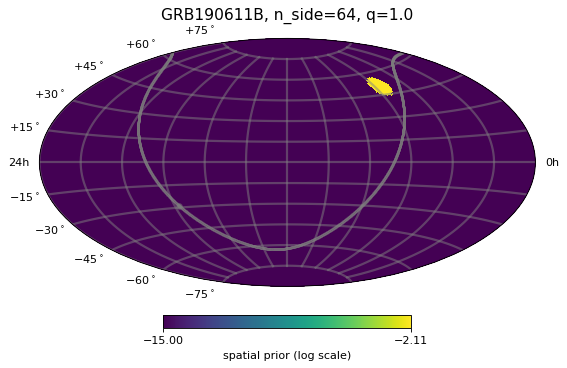

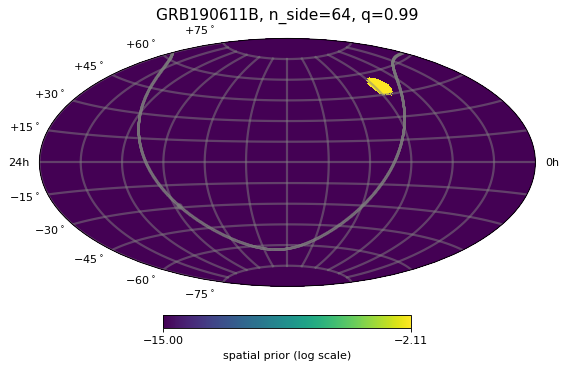

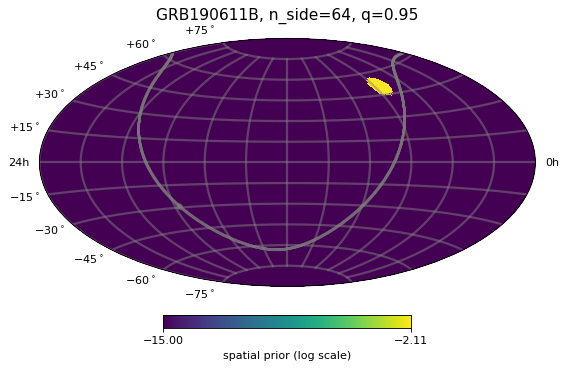

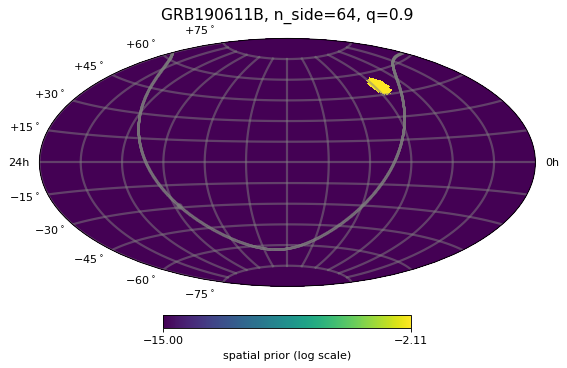

In [14]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB190611B"))
for q in [1.0, 0.99, 0.95, 0.90]:
    healpix[healpix < isf_healpix(healpix, q=q)] = 0
    fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict())
    mesh, cb = sp.plot_map(ax, np.log10(np.maximum(healpix, 1e-15)), n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'spatial prior (log scale)')
    ax.set_title("GRB190611B, n_side=64, q={}".format(q), fontsize=14, y=1.05)
    # plt.tight_layout()
    plt.show()


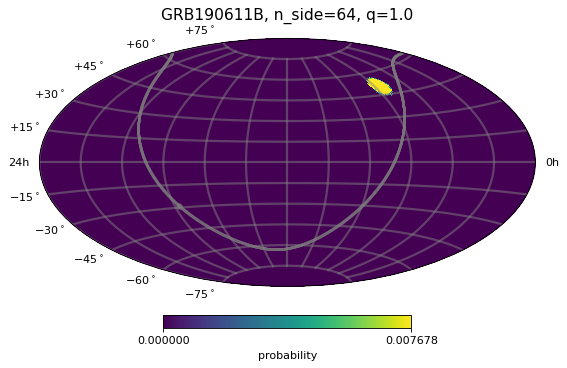

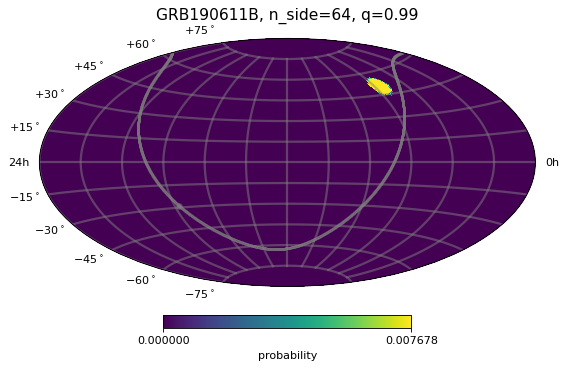

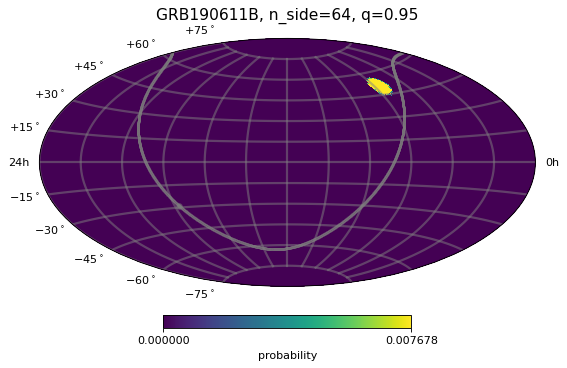

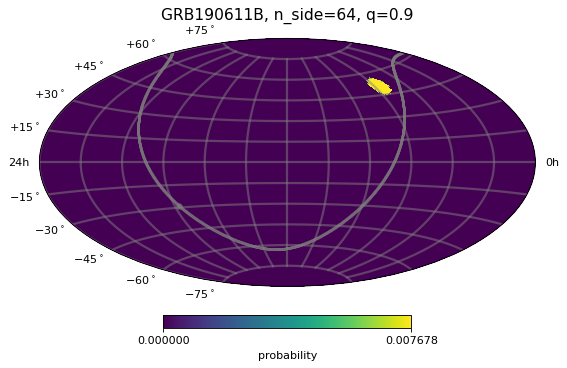

In [15]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB190611B"))
for q in [1.0, 0.99, 0.95, 0.90]:
    healpix[healpix < isf_healpix(healpix, q=q)] = 0
    fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict())
    mesh, cb = sp.plot_map(ax, healpix, 1e-15, n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'probability')
    ax.set_title("GRB190611B, n_side=64, q={}".format(q), fontsize=14, y=1.05)
    # plt.tight_layout()
    plt.show()




# GRECO datasets
<a id='greco-datesets'></a>

In [16]:
def angular_error_plot(true_energy, true_error):
    r'''from apizzuto'''
    true_energy = true_energy
    true_error = true_error
    a = ana[-1]
    data, sig = a.data, a.sig
    if true_energy:
        energy_array = sig.true_energy
        xlab = r'$E_\mathrm{true}$ [GeV]'
    else:
        energy_array = sig.energy
        xlab = r'$E_\mathrm{reco}$ [GeV]'
    if true_error:
        error_array = sig.dpsi_deg
        ylab = r'$\Delta\Psi[\mathrm{true,reco}]~[^\circ]$'
    else:
        error_array = sig.sigma_deg
        ylab = r'$\sigma~[^\circ]$'

    h = hl.hist_slide(
        (5,1),
        (energy_array, error_array),
        # E^-2 weighting
        sig.oneweight*sig.true_energy**-2,
        bins=(10**np.r_[0.0:4.0:.25], np.r_[0:180.01:1])
    )

    # normalize along the angular error axis
    h = h.normalize(1)
    # get 20%, 50%, and 80% quantiles
    h2 = h.contain(1, .2); h5 = h.contain(1, .5); h8 = h.contain(1, .8)
    soft_colors = cy.plotting.soft_colors
    fig, ax = plt.subplots()
    # plot quantiles, emphasize median
    color = soft_colors[0]
    hl.fill_between(ax, 0, h2, color=color, alpha=.3, drawstyle='line')
    hl.fill_between(ax, 0, h5, color=color, alpha=.3, drawstyle='line')
    hl.fill_between(ax, 0, h8, color=color, alpha=.3, drawstyle='line')
    hl.plot1d (ax, h5, color=color, lw=2, drawstyle='default')

    # trick to get the legend handles colored right
    # try testing what happens if you just do hl.fill_between(..., label='...')
    nans = [np.nan, np.nan]
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**1, label='80\%')
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**2, label='50\%')
    ax.plot (nans, nans, color=color, lw=5, alpha=1 - (1-0.3)**3, label='20\%')

    # labels etc
    fontsize=10
    ax.semilogx(); ax.set_xlabel(xlab, fontsize=fontsize)
    ax.set_ylabel(ylab, fontsize=fontsize)
    ax.set_xlim(h.bins[0][1], h.bins[0][-2]); ax.set_ylim(0)
    ax.legend(loc='upper right', fontsize=fontsize); plt.tight_layout()
    # if self.savefigs:
    #     for ftype in ['pdf', 'png']:
    #         plt.savefig(self.savepath + \
    #                     f'GRECO_energy_vs_error_true_energy_{true_energy}_true_errors_{true_error}.{ftype}', 
    #                     dpi=self.dpi, bbox_inches='tight')

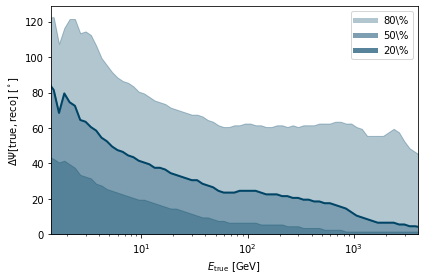

In [17]:
angular_error_plot(True, True)

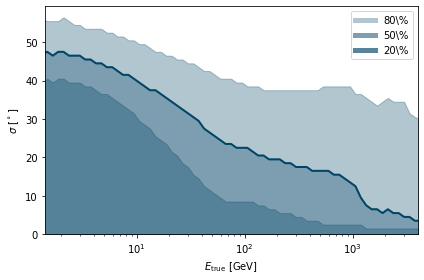

In [18]:
angular_error_plot(True, False)

# Time windows
<a id='time-windows'></a>

Text(0.5, 1.0, 'Size of Time Window')

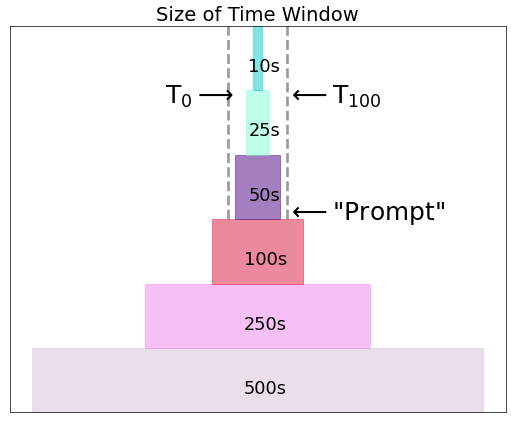

In [19]:
t100_start = -33
t100_end = +33
t_50 = (t100_start+t100_end)/2.
fig, ax = plt.subplots(figsize=(10,8), dpi=64)

l = 6.

tw=500
idx = 0
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='thistle')
ax.text(t_50-15, idx/l+0.05, '500s', fontsize=20)
tw=250
idx = 1
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='violet')
ax.text(t_50-15, idx/l+0.05, '250s', fontsize=20)
tw=100
idx = 2
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='crimson')
ax.text(t_50-15, idx/l+0.05, '100s', fontsize=20)
tw=50
idx = 3
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='indigo')
ax.text(t_50-10, idx/l+0.05, '50s', fontsize=20)
tw=25
idx = 4
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='aquamarine')
ax.text(t_50-10, idx/l+0.05, '25s', fontsize=20)
tw=10
idx = 5
ax.axvspan(t_50-tw/2., t_50+tw/2., idx/l, (idx+1)/l, alpha=0.5, color='darkturquoise')
ax.text(t_50-10, idx/l+0.05, '10s', fontsize=20)

ax.axvline(t100_start, 0.5, 1, linestyle='--', color='grey', alpha=0.8, linewidth=3)
ax.axvline(t100_end, 0.5, 1, linestyle='--', color='grey', alpha=0.8, linewidth=3)

ax.text(t100_start-70, 0.8, r'T$_{0}\longrightarrow$', fontsize=28)
ax.text(t100_end+0.011, 0.8, r'$\longleftarrow$T$_{100}$', fontsize=28)
ax.text(t100_end+0.012, 0.5, r'$\longleftarrow$"Prompt"', fontsize=28)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Size of Time Window', fontsize=22)

# Analysis
<a id='Analysis'></a>

## background scan
<a id='background-scan'></a>

### illustration
<a id='background-illustration'></a>

In [20]:
# real GRB
from scipy import sparse
file = DATA_DIR+"/plot/GRB180423A_batchSize1000_batchIndex0_tw500_backup.npz"
scan = sparse.load_npz(file)
maps = sparse.csr_matrix((0, hp.nside2npix(64)), dtype=float)
maps = sparse.vstack((maps, scan))

In [22]:
# 2,8,11,12,13,17,'23','28',

In [23]:
# np.min(ts_prior[ts_prior > 0])

/storage/hive/project/phy-taboada/cchen641/icecube/software/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon, lat, Z, **kw)


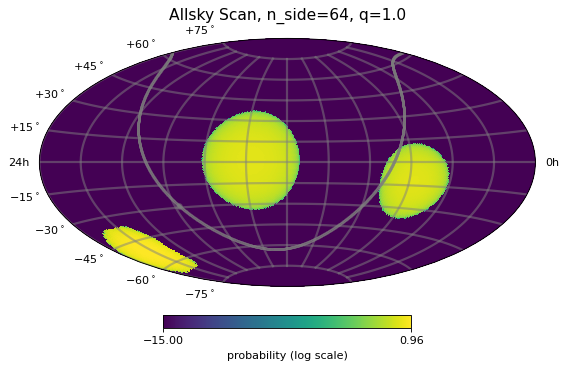

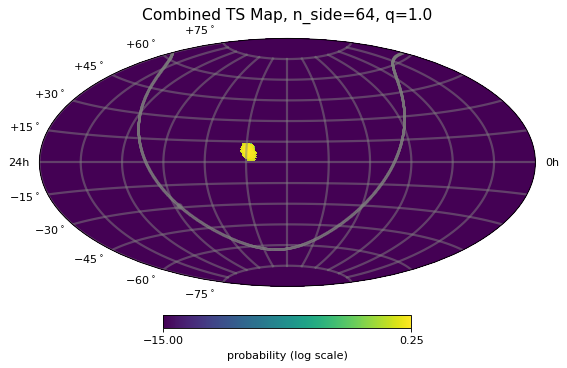

In [24]:
healpix = maps[23].toarray()[0]
q=1.
healpix[healpix < isf_healpix(healpix, q=q)] = 0
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(np.maximum(healpix, 1e-15)), n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability (log scale)')
ax.set_title("Allsky Scan, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()

################################### log scale ####################################################

probs = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB180423A"))
probs = np.maximum(probs, 1e-15)
ts_norm = np.log(np.amax(probs))
ts_prior = healpix + 2*(np.log(probs) - ts_norm)
ts_prior = np.maximum(ts_prior, 1e-15)
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(np.maximum(ts_prior, 1e-15)), n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability (log scale)')
ax.set_title("Combined TS Map, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()


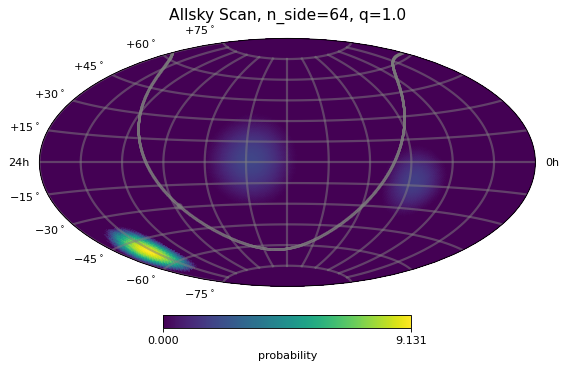

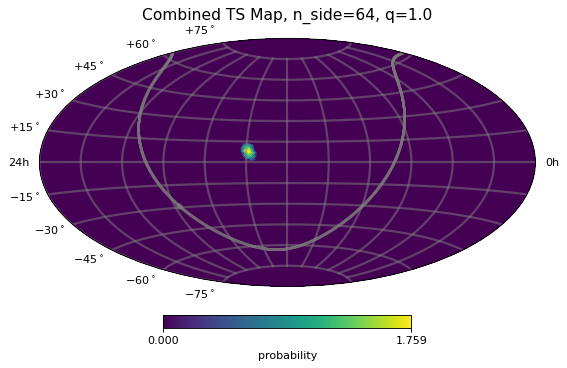

In [26]:
q=1.
healpix[healpix < isf_healpix(healpix, q=q)] = 0
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, healpix, 1e-15, n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability')
ax.set_title("Allsky Scan, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()


######################################### linear scale ##############################################

probs = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB180423A"))
probs = np.maximum(probs, 1e-15)
ts_norm = np.log(np.amax(probs))
ts_prior = healpix + 2*(np.log(probs) - ts_norm)
ts_prior = np.maximum(ts_prior, 1e-15)
fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                        subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.maximum(ts_prior, 1e-15), n_ticks=2)
kw = dict(color='.5', alpha=.5, linewidth=2)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'probability')
ax.set_title("Combined TS Map, n_side=64, q={}".format(q), fontsize=14, y=1.05)
# plt.tight_layout()
plt.show()



### background TS distribution
<a id='background-TS-distribution'></a>

In [28]:
def plot_bg_TS(array, label, norm=True, ax=None, show=True, grid=False, chi2fit=False, chi2fitlable=False):
    """
    Plot TS distribution(s) and produce one plot
    
    Parameters
    ----------
    array : one 1-D numpy array OR a python list of 1-D numpy arrays
        If it has a shape of (number, ): then only one distribution
        If it is a list of length N: we expect N distributions in one plot
        
    label : str OR a list of strs
        Label(s) for each individual distribution
        
    norm : bool
        wether we should normalize the distribution
        
    ax : matplotlib axes object
        If there are a set of axes outside the function, passing them through
        
    show: bool
        True if there is no plt.show() outside this function call
        
    grid: bool
        Show grid or not
        
    chi2fit : bool
        Show chi2fit line or not
    chi2fitlable : bool
        Show chi2fit labels or not
    
    Returns
    -------
    N/A
    
    See also
    -------
    N/A
    """
    try: 
        _ = array.shape
        array = [array]
    except:
        pass
    if type(label) == str:
        label = [label]
    
    if ax is None:
        fig, ax = plt.subplots(dpi=120)
        
    for arr, lb in zip(array, label):
        bg = cy.dists.Chi2TSD(arr)
        h = bg.get_hist(bins=50)
        color = next(ax._get_lines.prop_cycler)['color']
        hl.plot1d(ax, h, crosses=True,
                label='{}'.format(lb),
                 color=color)
        if chi2fit:
            x = h.centers[0]
            norm = h.integrate().values
            if not chi2fitlable:
                ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', color=color)
            else:
                ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', color=color,
                        label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

    if show:
        ax.set_yscale('symlog')
        ax.set_xlabel(r'TS')
        ax.set_ylabel(r'number of trials')
        ax.legend()
        ax.grid(grid)
        plt.tight_layout()
    

In [29]:
# grb_name = "GRB180423A"    # real healpix example
# grb_name = "GRB190611B"    # fake healpix example

/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


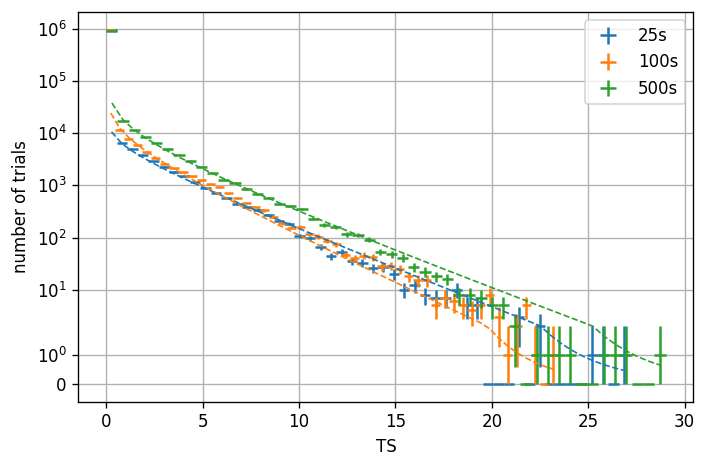

In [30]:
## real
files = glob(ANA_DIR+"/allsky_scan/with_prior_background/tw*/GRB180423A*.npz")
files.sort(key=lambda x: int(x[x.find("_tw") + len("_tw"): x.find("_NTrial")]))
TSs = [sparse.load_npz(file).toarray()[0] for file in files]
indices = [1,3,5]
plot_bg_TS([TSs[i] for i in indices], 
           [['10s', '25s','50s','100s','250s','500s'][i] for i in indices], 
           grid=True,
          chi2fit=True)

/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


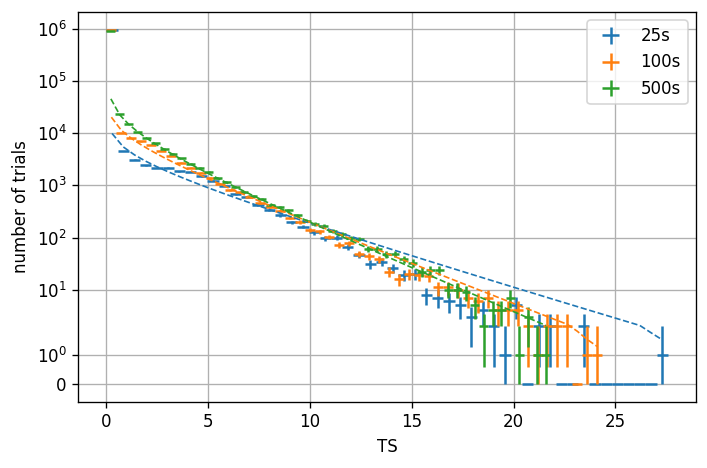

In [31]:
## fake
files = glob(ANA_DIR+"/allsky_scan/with_prior_background/tw*/GRB190611B*.npz")
files.sort(key=lambda x: int(x[x.find("_tw") + len("_tw"): x.find("_NTrial")]))
TSs = [sparse.load_npz(file).toarray()[0] for file in files]
indices = [1,3,5]
plot_bg_TS([TSs[i] for i in indices], 
           [['10s', '25s','50s','100s','250s','500s'][i] for i in indices],
          grid=True,
          chi2fit=True)